
# **Time Series Forecasting with ARIMA and SARIMA Models**  

## **Project Overview**  
This project applies **ARIMA (AutoRegressive Integrated Moving Average)** and **SARIMA (Seasonal ARIMA)** models to analyze and forecast **electricity sales trends** in the United States. Using **monthly electricity consumption data from 2010 to 2023**, the study aims to capture long-term trends and seasonal patterns in power usage across different economic sectors.  

By leveraging **time series modeling techniques**, this analysis provides **data-driven insights** for energy policymakers, utility companies, and researchers interested in demand forecasting.  

---  

## **Dataset Overview**  
- **Source:** U.S. Energy Information Administration (EIA) - Monthly Form EIA-861M  
- **Time Frame:** January 2010 – December 2023 (168 monthly observations)  
- **Key Variable:**  
  - `Sales_total` → Aggregated electricity consumption across **residential, commercial, industrial, and transportation** sectors.  
- **Other Features:** Revenue, customer counts, and sector-specific sales data.  

---

## **Data Preprocessing**  
To ensure accurate forecasting, several preprocessing steps were applied:  
✔️ **Date Formatting**: Combined `Year` and `Month` into a **datetime index** for time series analysis.  
✔️ **Data Cleaning**: Removed commas from numerical values and converted key variables to float format.  
✔️ **Stationarity Check**: Conducted **Augmented Dickey-Fuller (ADF) test** to assess stationarity.  
✔️ **Differencing & Transformation**: Applied **first-order differencing** to stabilize the series before modeling.  

---

## **ARIMA (AutoRegressive Integrated Moving Average) Model**  

### **Why ARIMA?**  
ARIMA is particularly useful for analyzing **non-seasonal time series data** with trends and patterns. Its ability to model both **autoregressive (AR) and moving average (MA) processes**, while incorporating **differencing (I) to achieve stationarity**, makes it a strong choice for short-term forecasting.  

### **Usefulness (Pros)**  
- **Flexibility**: Adaptable to various time series datasets.  
- **Accuracy**: Provides **reliable** forecasts for non-seasonal data.  
- **Simplicity**: Despite its theoretical complexity, **implementation in Python or R is straightforward**.  

### **Limitations (Cons)**  
- **Requires Stationarity**: Data must be transformed before applying ARIMA.  
- **Not Ideal for Seasonal Data**: ARIMA cannot inherently model **strong seasonality**.  
- **Parameter Selection**: Identifying the optimal **(p, d, q)** values requires **grid search or auto-selection methods**.  

### **RIMA Model Implementation**  
- Conducted **ADF test** → Confirmed that `Sales_total` required differencing for stationarity.  
- Used **ACF/PACF plots** to determine potential **(p, d, q) values**.  
- Applied **Auto-ARIMA**, which selected **ARIMA(2,0,2)** as the best model.  
- Evaluated **residuals** to ensure no significant autocorrelation.  

### **ARIMA Forecast Results**  
The ARIMA model effectively captured the overall trend in electricity sales.  
The **forecast for the next 36 months** provided valuable insights into expected energy consumption.  

---

## **SARIMA (Seasonal ARIMA) Model**  

Since electricity demand exhibits **seasonal variations**, SARIMA was used to **enhance forecasting accuracy**. SARIMA extends ARIMA by incorporating a **seasonal component**, represented as:  

**SARIMA(p, d, q) × (P, D, Q, s)**  
- **(p, d, q):** Non-seasonal components.  
- **(P, D, Q, s):** Seasonal components, where **s=12** for monthly seasonality.  

### **SARIMA Model Implementation**  
- Applied **seasonal decomposition** to visualize **trend, seasonality, and residuals**.  
- Used **Auto-SARIMA**, which selected **SARIMA(1,0,2) × (2,1,2,12)** as the best model.  
- Evaluated **residual diagnostics**, forecasting accuracy, and plotted confidence intervals.  

### **SARIMA Forecast Results**  
- SARIMA successfully captured **seasonal patterns** in electricity consumption.  
- The **36-month forecast** highlighted cyclical variations in demand.  

---

## **Key Takeaways**  
- **ARIMA is effective for short-term, trend-based forecasting** but lacks seasonal adaptation.  
- **SARIMA improves forecasting accuracy** by capturing annual cycles in energy demand.  
- **Both models provide valuable insights** for **energy resource planning** and **demand management**.  


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings

In [3]:
# Load datasets
data = pd.read_excel('/Users/latifayari/Desktop/DataProjects/PredictiveEnalytics/Elec_sales.xlsx', engine='openpyxl')
print(data.head())
print(data.shape)
print(data.dtypes)

   Year  Month  Revenue_residential  Sales_residential  Customers_residential  \
0  2023     12             18659020          118916960              141942234   
1  2023     11             16501182          101906587              141638998   
2  2023     10             17021917          103313774              141873678   
3  2023      9             21601604          132807006              141394603   
4  2023      8             25693309          161460192              142091093   

   Price_residential  Revenue_commercial  Sales_commercial  \
0          15.690798          13652809.0         111511827   
1          16.192458          13645725.0         109756483   
2          16.475941          15047055.0         118207853   
3          16.265410          16537574.0         126545787   
4          15.913092          18102204.0         138389572   

   Customers_commercial  Price_commercial  ...  Customers_industrial  \
0              19410068         12.243373  ...               1083495

In [4]:
# Remove commas and convert specified columns to numeric
columns_to_clean = [
    "Revenue_residential", "Sales_residential", "Customers_residential",
    "Revenue_commercial", "Sales_commercial", "Customers_commercial",
    "Revenue_industrial", "Sales_industrial", "Customers_industrial",
    "Revenue_transportation", "Sales_transportation", "Revenue_total",
    "Sales_total", "Customers_total"
]

for col in columns_to_clean:
    data[col] = data[col].replace(",", "", regex=True).astype(float)

In [5]:
# Combine 'Year' and 'Month' into a datetime index
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
data.set_index('Date', inplace=True)

In [6]:
# Check for missing values
print(data.isnull().sum())

Year                        0
Month                       0
Revenue_residential         0
Sales_residential           0
Customers_residential       0
Price_residential           0
Revenue_commercial          0
Sales_commercial            0
Customers_commercial        0
Price_commercial            0
Revenue_industrial          0
Sales_industrial            0
Customers_industrial        0
Price_industrial            0
Revenue_transportation      0
Sales_transportation        0
Customers_transportation    0
Price_transportation        0
Revenue_total               0
Sales_total                 0
Customers_total             0
Price_total                 0
dtype: int64


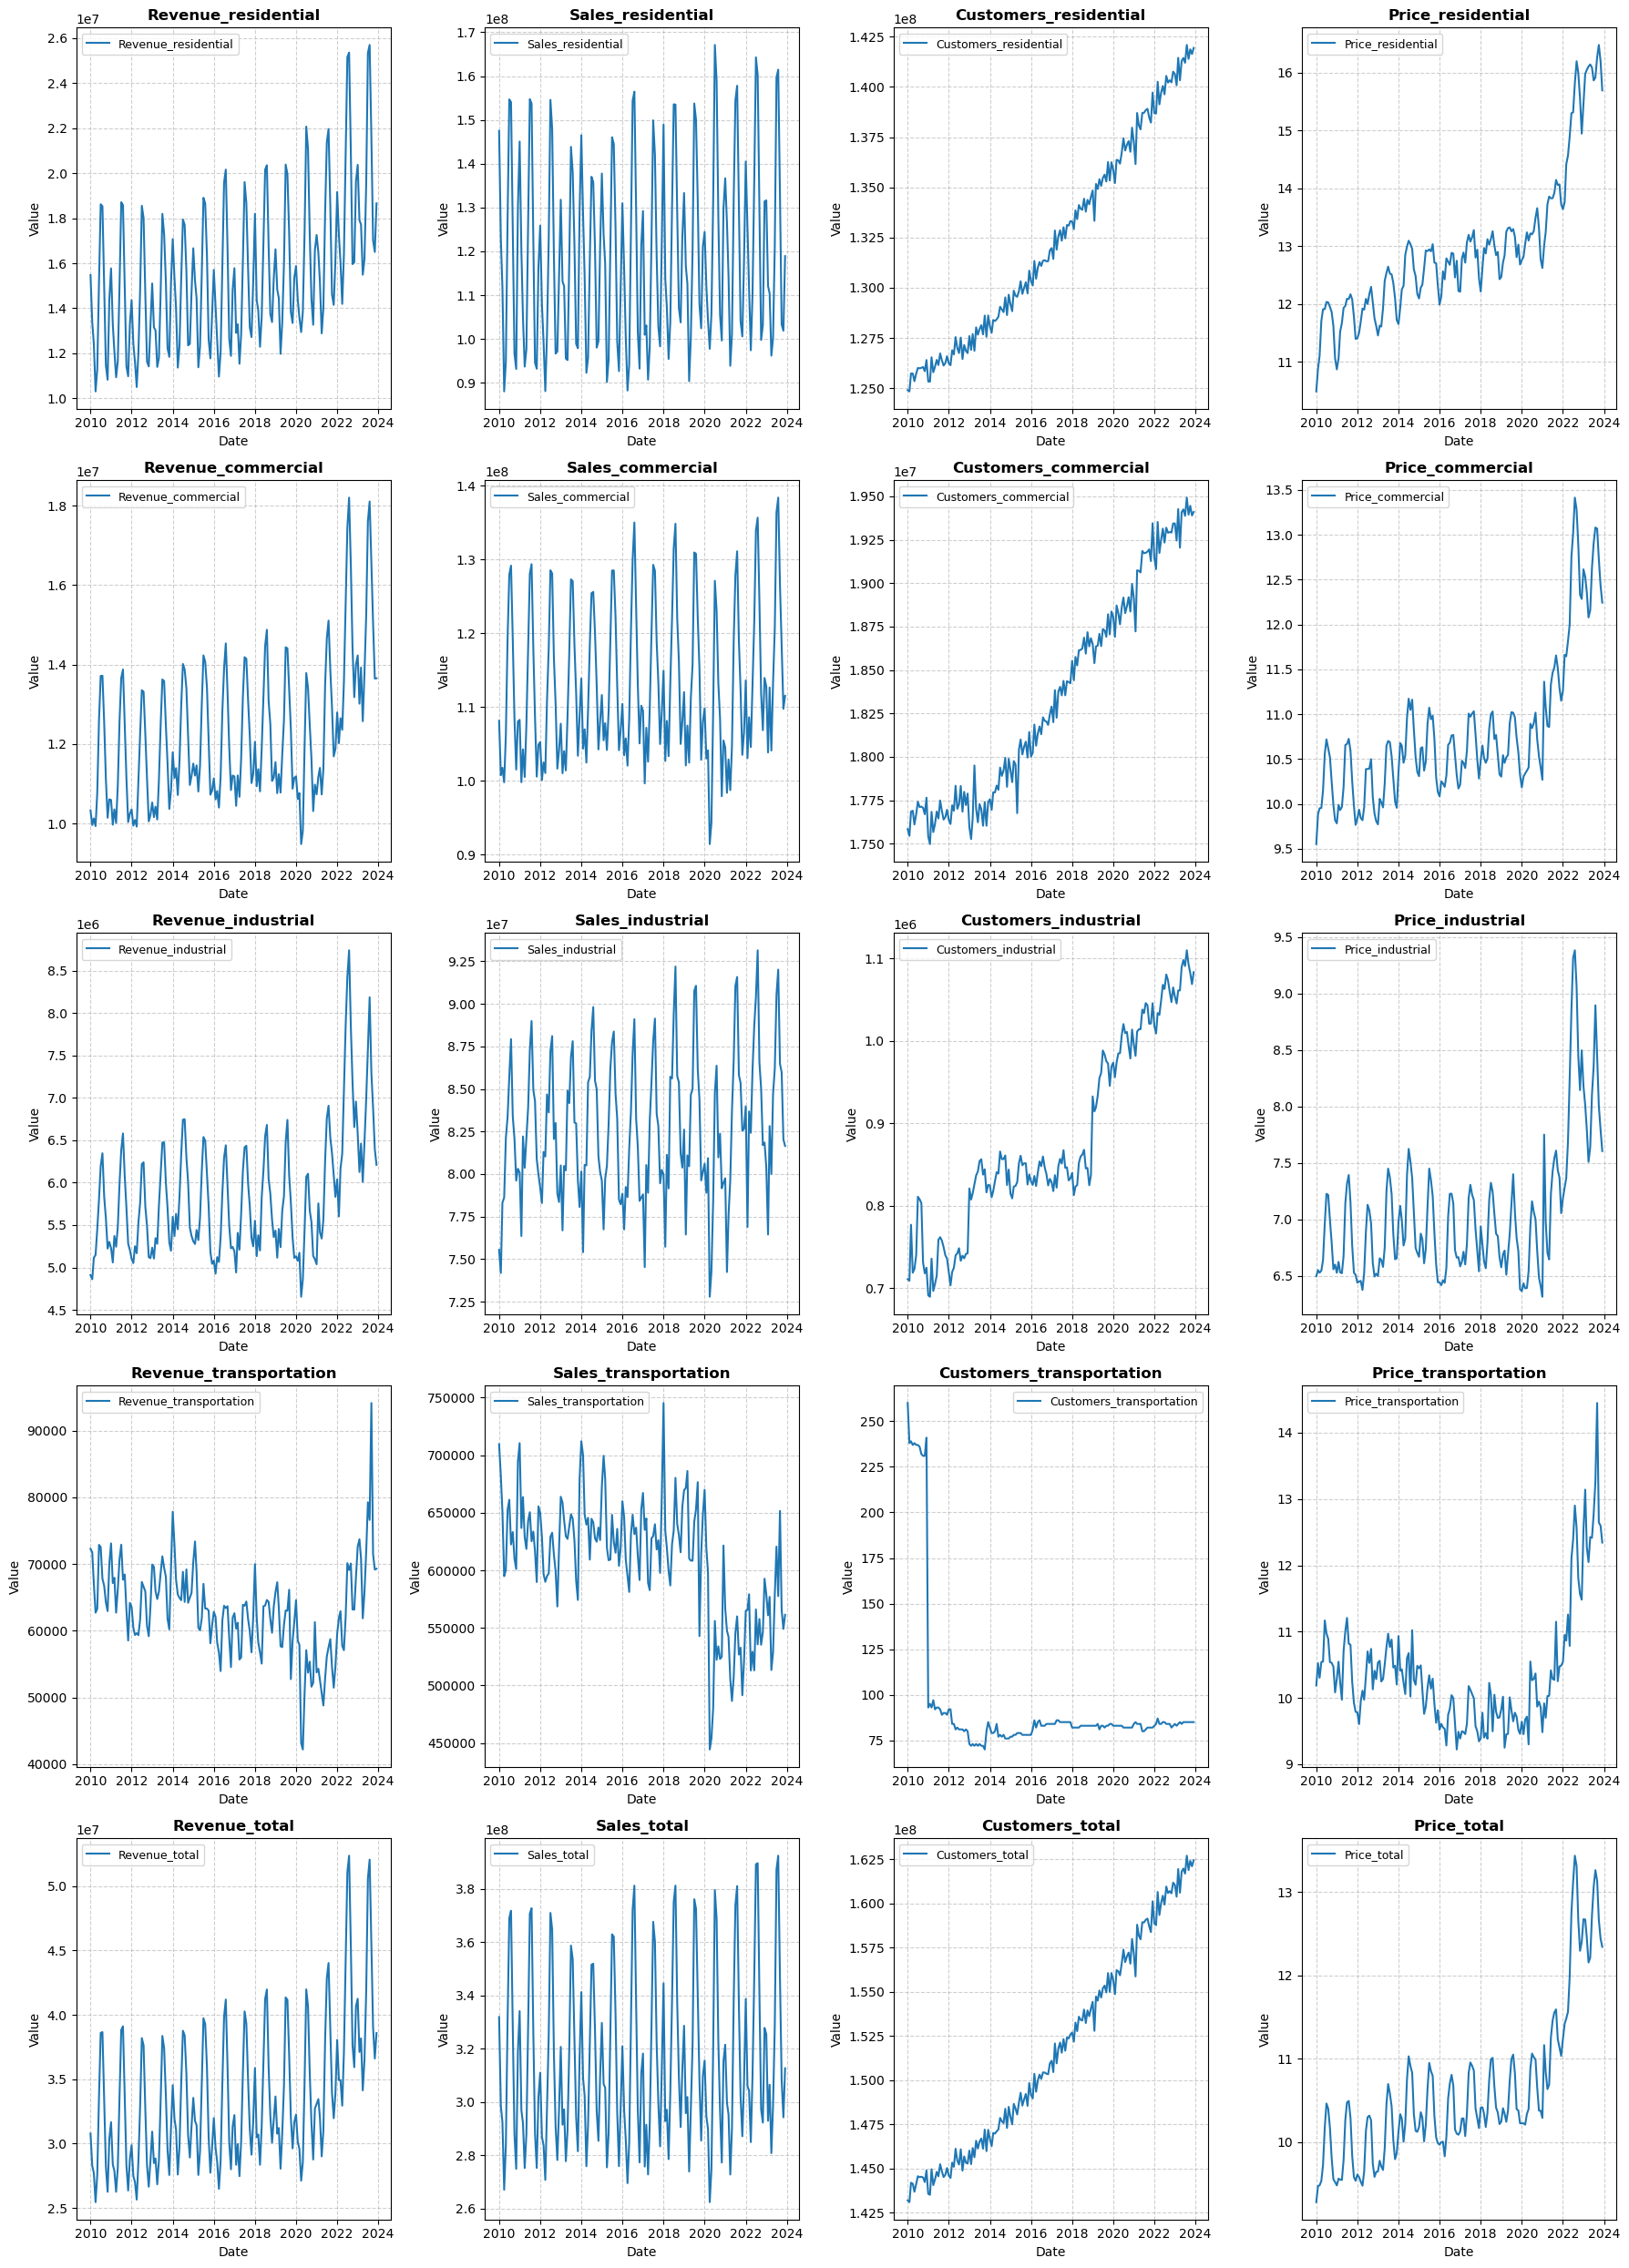

In [7]:
# --- Data visualization ---
# Time series dataset visualization
variables_to_plot = [
    "Revenue_residential", "Sales_residential", "Customers_residential", "Price_residential",
    "Revenue_commercial", "Sales_commercial", "Customers_commercial", "Price_commercial",
    "Revenue_industrial", "Sales_industrial", "Customers_industrial", "Price_industrial",
    "Revenue_transportation", "Sales_transportation", "Customers_transportation", "Price_transportation",
    "Revenue_total", "Sales_total", "Customers_total", "Price_total"
]

num_vars = len(variables_to_plot)
n_cols = 4  # Number of columns in the grid
n_rows = -(-num_vars // n_cols)  # Ceiling division for rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, var in enumerate(variables_to_plot):
    axes[i].plot(data.index, data[var], label=var, linewidth=1.5)
    axes[i].set_title(var, fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Date", fontsize=10)
    axes[i].set_ylabel("Value", fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, linestyle='--', alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
# --- Descriptive statistics ---
sales_total_stats = data['Sales_total'].describe()
print(sales_total_stats)

count    1.680000e+02
mean     3.150593e+08
std      3.189994e+07
min      2.624006e+08
25%      2.914379e+08
50%      3.081533e+08
75%      3.321485e+08
max      3.924360e+08
Name: Sales_total, dtype: float64


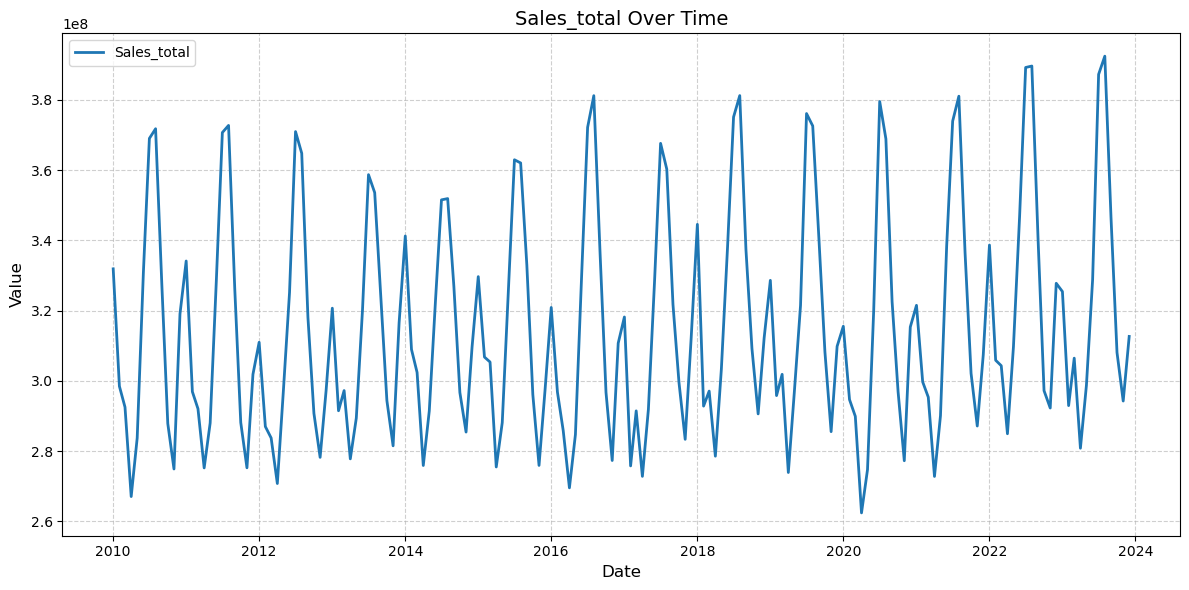

In [9]:
# --- Plotting Sales_total ---
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Sales_total"], label="Sales_total", linewidth=2)
plt.title("Sales_total Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
# --- Stationarity check ---
# Augmented Dickey-Fuller test for stationarity
series = data['Sales_total']
result = adfuller(series)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -2.340837748506466
p-value: 0.15913493694575032
Critical Values: {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}
The time series is not stationary.


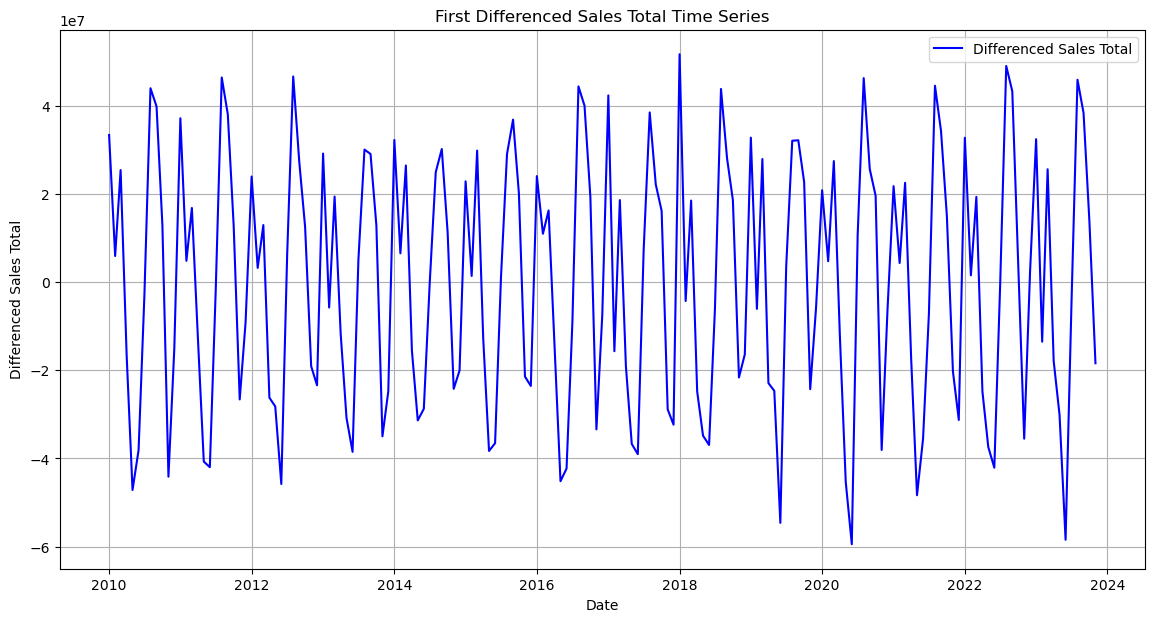

ADF Statistic: -6.973758005223728
p-value: 8.532554237370605e-10
Critical Values: {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}
The differenced series is stationary.


In [11]:
# First-order differencing
data['Sales_total_diff'] = data['Sales_total'].diff().dropna()

plt.figure(figsize=(14, 7))
plt.plot(data.index[1:], data['Sales_total_diff'][1:], label='Differenced Sales Total', color='blue')
plt.title('First Differenced Sales Total Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Sales Total')
plt.grid(True)
plt.legend()
plt.show()

result_diff = adfuller(data['Sales_total_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:', result_diff[4])

if result_diff[1] <= 0.05:
    print("The differenced series is stationary.")
else:
    print("The differenced series is still not stationary.")


<Figure size 2000x1200 with 0 Axes>

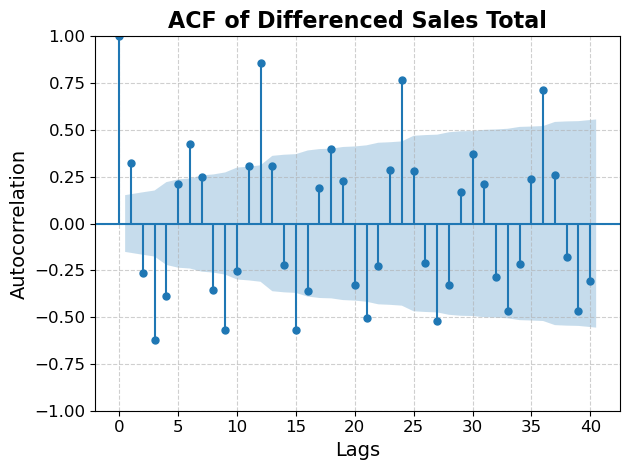

In [12]:
# --- ACF and PACF plots ---
# Plot ACF
plt.figure(figsize=(20, 12))
plot_acf(data['Sales_total_diff'].dropna(), lags=40)
plt.title('ACF of Differenced Sales Total', fontsize=16, fontweight='bold')
plt.xlabel('Lags', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<Figure size 2000x1200 with 0 Axes>

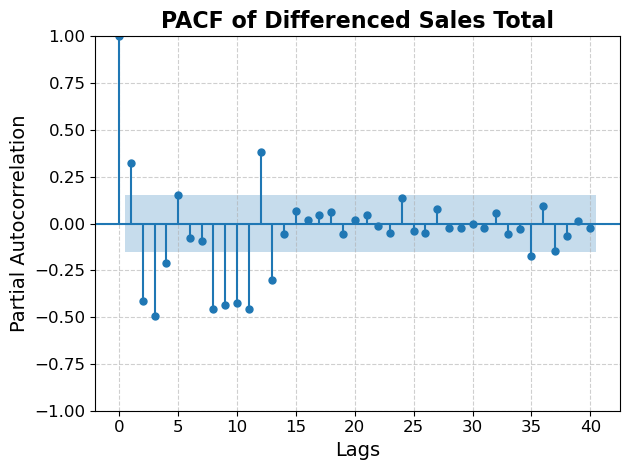

In [13]:
# Plot PACF
plt.figure(figsize=(20, 12))
plot_pacf(data['Sales_total_diff'].dropna(), lags=40)
plt.title('PACF of Differenced Sales Total', fontsize=16, fontweight='bold')
plt.xlabel('Lags', fontsize=14)
plt.ylabel('Partial Autocorrelation', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
# --- ARIMA Model ---
# Grid search for ARIMA parameters
warnings.filterwarnings("ignore")

def arima_grid_search(time_series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = ARIMA(time_series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print(f"ARIMA{(p, d, q)} AIC:{aic}")
        except Exception as e:
            print(f"ARIMA{(p, d, q)} failed. Error: {e}")
    print(f"Best ARIMA Model: ARIMA{best_cfg} AIC:{best_score}")
    return best_cfg

In [15]:
# Define parameter ranges for grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

In [16]:
# Perform grid search
best_order = arima_grid_search(data['Sales_total_diff'].dropna(), p_values, d_values, q_values)

ARIMA(0, 0, 0) AIC:6898.193973103793
ARIMA(0, 0, 1) AIC:6184.8802930167
ARIMA(0, 0, 2) AIC:6163.984054549923
ARIMA(0, 1, 0) AIC:6219.929602285402
ARIMA(0, 1, 1) AIC:6220.872883578366
ARIMA(0, 1, 2) AIC:6155.741677445052
ARIMA(1, 0, 0) AIC:6192.802948998712
ARIMA(1, 0, 1) AIC:6185.816744513435
ARIMA(1, 0, 2) AIC:6146.219076762218
ARIMA(1, 1, 0) AIC:6221.359804089588
ARIMA(1, 1, 1) AIC:6161.510761078626
ARIMA(1, 1, 2) AIC:6155.699964245203
ARIMA(2, 0, 0) AIC:6162.791209362127
ARIMA(2, 0, 1) AIC:6097.18371966827
ARIMA(2, 0, 2) AIC:6067.726315492792
ARIMA(2, 1, 0) AIC:6217.700177031489
ARIMA(2, 1, 1) AIC:6138.465194997881
ARIMA(2, 1, 2) AIC:6100.557264415476
Best ARIMA Model: ARIMA(2, 0, 2) AIC:6067.726315492792


In [17]:
#Fit ARIMA model using auto_arima
arima_model_auto = auto_arima(
    data['Sales_total_diff'].dropna(),
    seasonal=False,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
print("Auto ARIMA Model Summary:")
print(arima_model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6207.492, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6190.805, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6182.881, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6183.819, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6159.810, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6163.009, Time=0.02 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.191 seconds
Auto ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  167
Model:               SARIMAX(0, 0, 2)   Log Likelihood  

In [18]:
# Fit ARIMA model with specified (p, d, q)
arima_model = ARIMA(data['Sales_total_diff'].dropna(), order=(2, 0, 2))
arima_model_fit = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_model_fit.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:       Sales_total_diff   No. Observations:                  167
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3027.863
Date:                Sun, 09 Mar 2025   AIC                           6067.726
Time:                        19:12:20   BIC                           6086.434
Sample:                             0   HQIC                          6075.319
                                - 167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.152e+05      1e-09   1.15e+14      0.000    1.15e+05    1.15e+05
ar.L1          1.0015      0.004    262.428      0.000       0.994       1.009
ar.L2         -0.9993      0.00

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

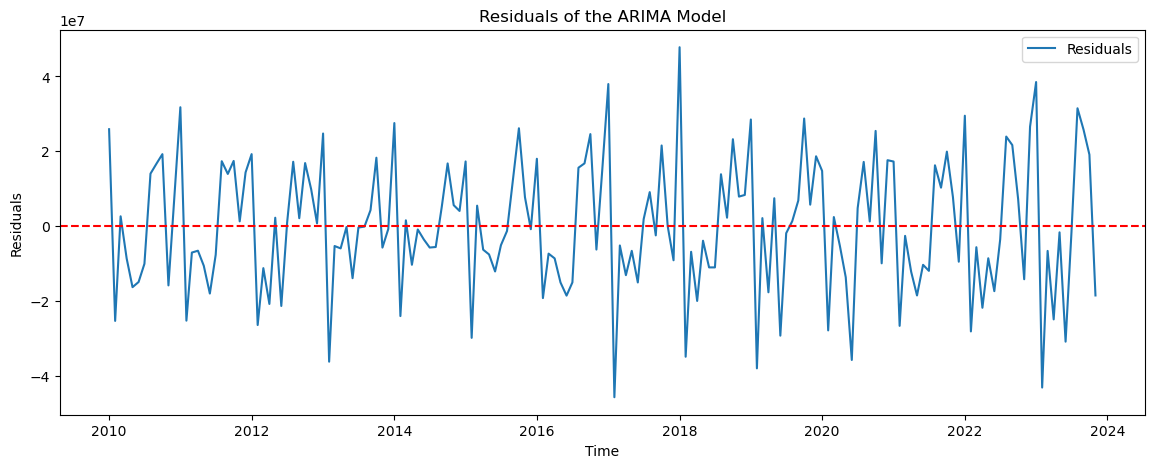

In [19]:
# Plot the residuals
residuals = arima_model_fit.resid

# Plot residuals over time
plt.figure(figsize=(14, 5))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of the ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

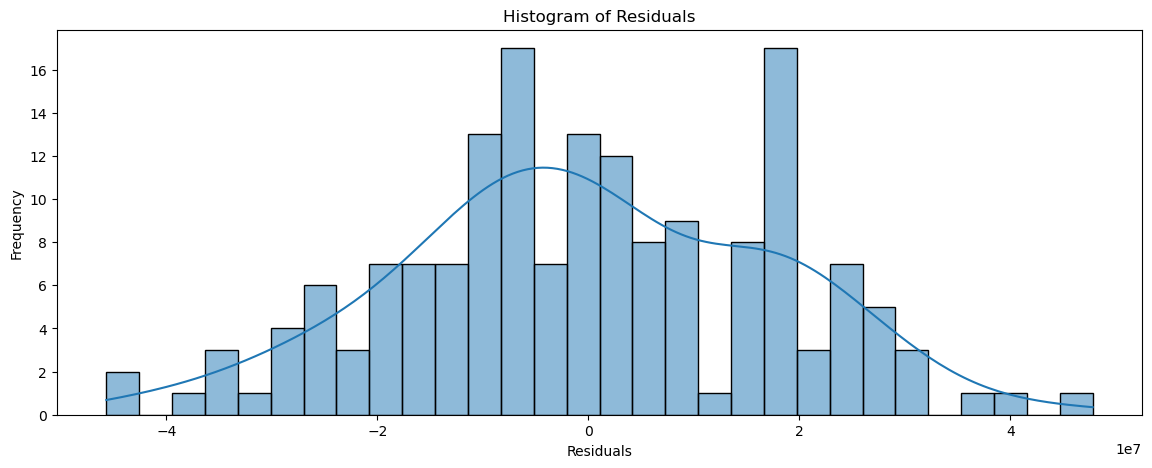

In [23]:
#Plot histogram of the residuals
plt.figure(figsize=(14, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#QQ plot for normality check
plt.figure(figsize=(10, 10))
qqplot(residuals, line='45', ax=plt.gca())
plt.title('QQ Plot of Residuals')
plt.show()

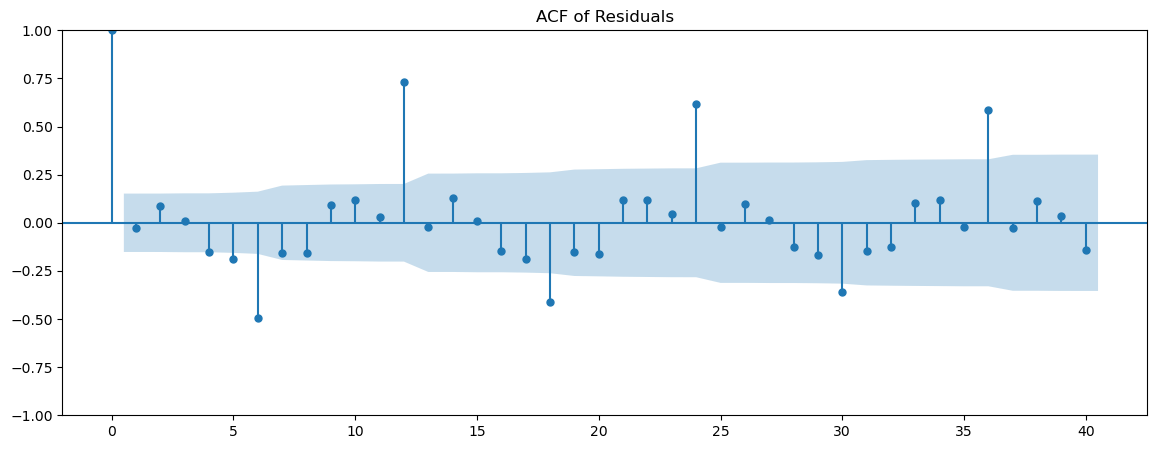

In [24]:
#Plot ACF of the residuals to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(14, 5))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.show()

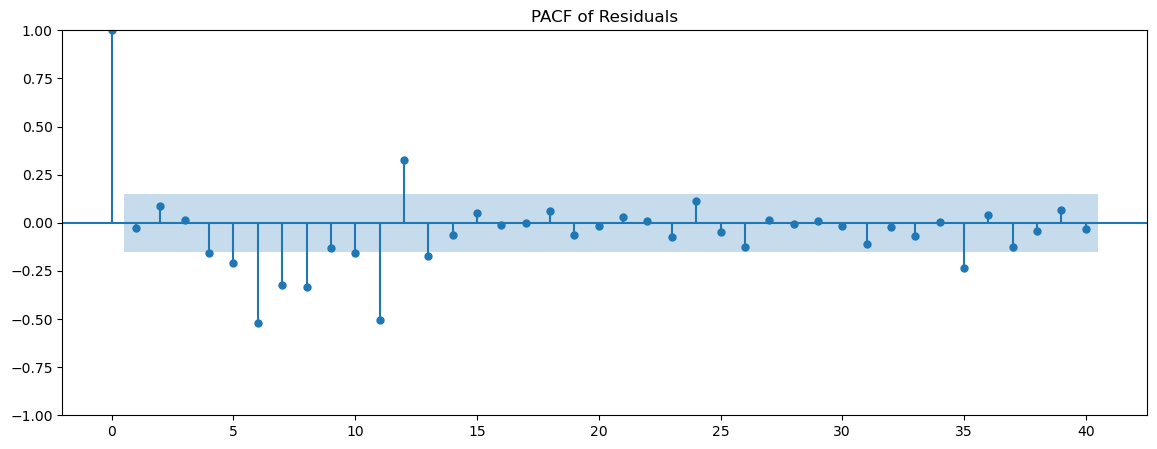

In [25]:
#Plot PACF of the residuals to check for partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(14, 5))
plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF of Residuals')
plt.show()

In [26]:
#Forecast with ARIMA model
arima_forecast = arima_model_fit.get_forecast(steps=36)
arima_forecast_index = pd.date_range(start=data.index[1] + pd.DateOffset(months=1), periods=36, freq='M')
arima_forecast_values = arima_forecast.predicted_mean

In [27]:
#Re-integrate the forecasted differenced values back to original scale
last_observed = data['Sales_total'].iloc[-1]
arima_forecast_values_original = last_observed + arima_forecast_values.cumsum()

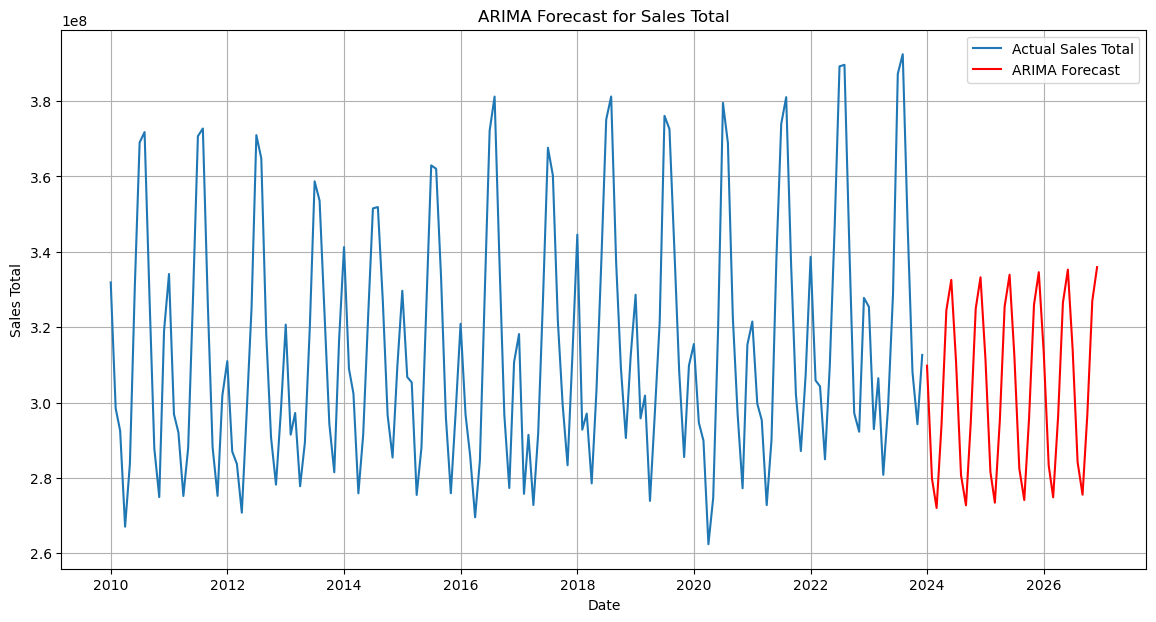

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Sales_total'], label='Actual Sales Total')
plt.plot(arima_forecast_index, arima_forecast_values_original, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast for Sales Total')
plt.xlabel('Date')
plt.ylabel('Sales Total')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# --- SARIMA Model ---

# Decomposing the time series
decomposition = seasonal_decompose(data['Sales_total'], model='additive', period=12)

In [30]:
# Extracting the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

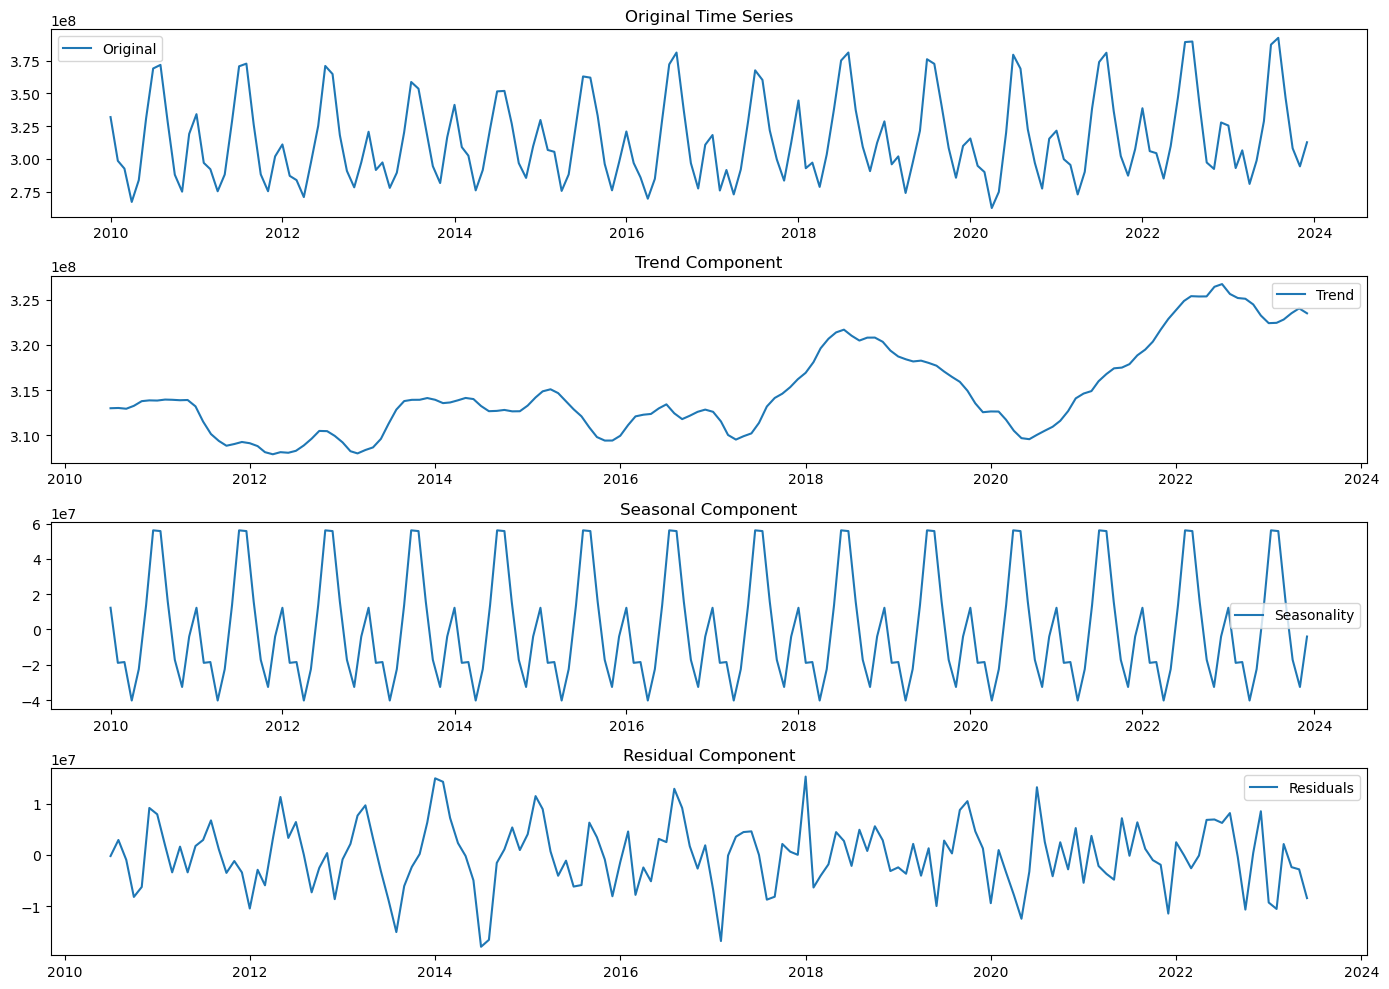

In [31]:
# Plotting the original series and its components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data.index, data['Sales_total'], label='Original')
plt.title('Original Time Series')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(data.index, trend, label='Trend')
plt.title('Trend Component')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(data.index, seasonal, label='Seasonality')
plt.title('Seasonal Component')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(data.index, residual, label='Residuals')
plt.title('Residual Component')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [32]:
#Fit SARIMA model using auto_arima
sarima_model_auto = auto_arima(
    data['Sales_total'],
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
print("Auto SARIMA Model Summary:")
print(sarima_model_auto.summary())

#Fit SARIMA model with specified parameters
sarima_model_manual = SARIMAX(
    data['Sales_total'],
    order=(1, 0, 2),  # Non-seasonal pdq
    seasonal_order=(2, 1, 2, 12)  # Seasonal P, D, Q, s
)
sarima_model_fit = sarima_model_manual.fit()
print("SARIMA Model (Manual Order) Summary:")
print(sarima_model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=5469.633, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5472.709, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5466.112, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=5462.923, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5472.076, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=5461.071, Time=0.02 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=5462.931, Time=0.11 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=5463.327, Time=0.36 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=5465.605, Time=0.08 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=5464.003, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5464.203, Time=0.02 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=5465.842, Time=0.09 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=5460.268, Time=0.01 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=5462.237, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1

 This problem is unconstrained.



At iterate    5    f=  1.64859D+01    |proj g|=  4.10960D+00

At iterate   10    f=  1.62243D+01    |proj g|=  7.33134D-01

At iterate   15    f=  1.61420D+01    |proj g|=  1.27596D-01

At iterate   20    f=  1.61246D+01    |proj g|=  1.87474D-01

At iterate   25    f=  1.61122D+01    |proj g|=  9.73484D-01

At iterate   30    f=  1.60964D+01    |proj g|=  2.12206D-01

At iterate   35    f=  1.60947D+01    |proj g|=  2.32713D-02

At iterate   40    f=  1.60945D+01    |proj g|=  4.98268D-02

At iterate   45    f=  1.60928D+01    |proj g|=  1.36591D-01

At iterate   50    f=  1.60926D+01    |proj g|=  7.46956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

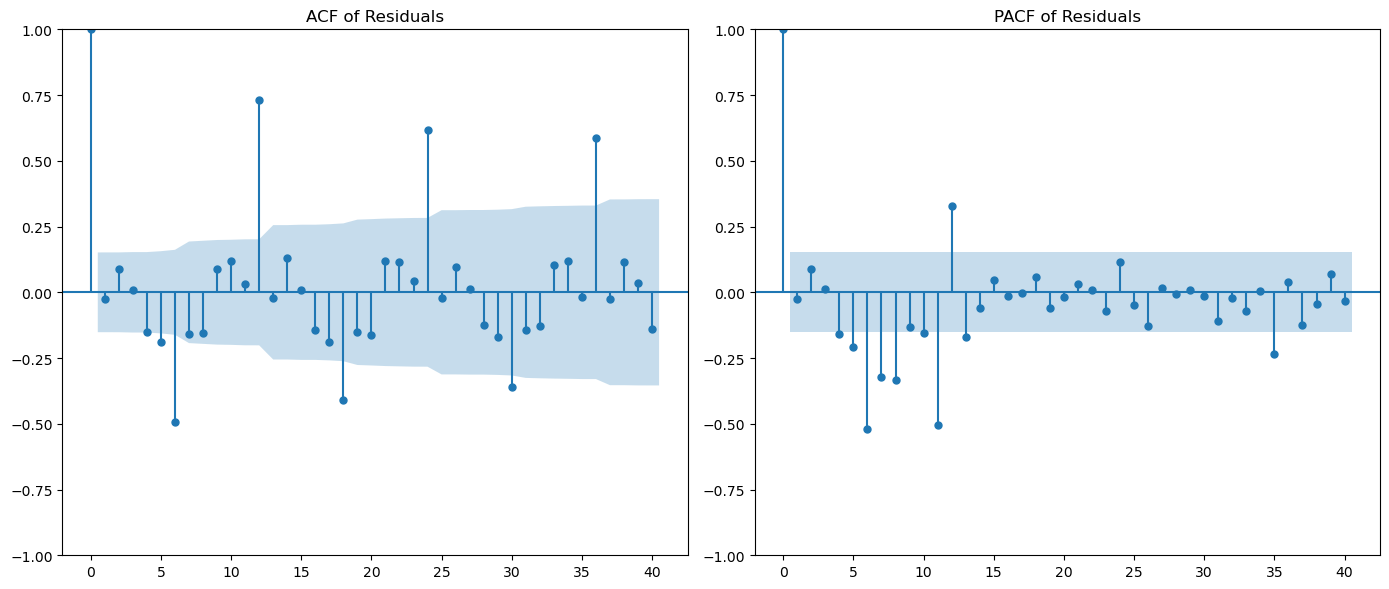

In [35]:
# Step 1: Residual plot
# ACF and PACF plots of residuals
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(residuals, lags=40, ax=plt.gca(), title='ACF of Residuals')

plt.subplot(122)
plot_pacf(residuals, lags=40, ax=plt.gca(), title='PACF of Residuals')

plt.tight_layout()
plt.show()

In [37]:
#Forecast with the SARIMA model
sarima_forecast = sarima_model_fit.get_forecast(steps=36)
sarima_forecast_index = pd.date_range(start=data.index[1] + pd.DateOffset(months=1), periods=36, freq='M')
sarima_forecast_values = sarima_forecast.predicted_mean

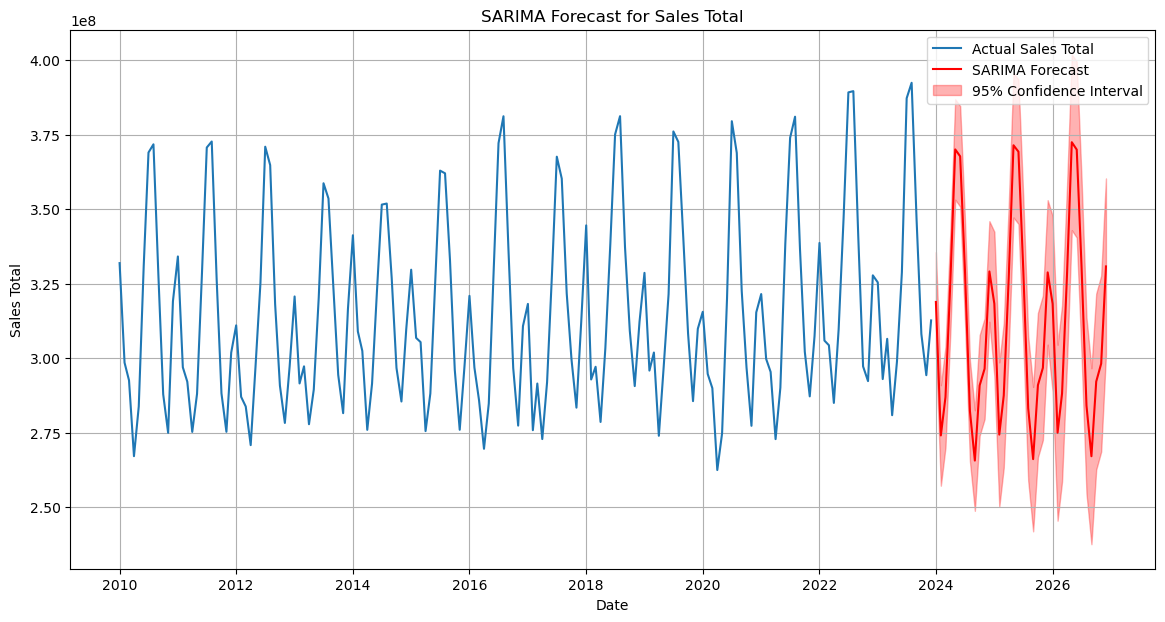

In [38]:
#Plot SARIMA forecast with confidence intervals
sarima_forecast_conf_int = sarima_forecast.conf_int()
lower_bound = sarima_forecast_conf_int.iloc[:, 0]
upper_bound = sarima_forecast_conf_int.iloc[:, 1]

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Sales_total'], label='Actual Sales Total')
plt.plot(sarima_forecast_index, sarima_forecast_values, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_index, lower_bound, upper_bound, color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Forecast for Sales Total')
plt.xlabel('Date')
plt.ylabel('Sales Total')
plt.legend()
plt.grid(True)
plt.show()